# Variational Autoencoder based Anomaly Dection using Reconstruction Probability
> by jupyter notebook

toc: true
badges: true
branch: master
categories: ['deeplearning', 'anomaly detection']

## Backgraound

### Anomaly deteciton

anomaly detection 방법은 다음과 같은 3가지 관점으로 분류할 수 있다.

- statistical
- proximity
- deviation

**statistical관점**은 data가 특정 분포를 따른다고 가정한다. 예를 들어, parametric model인 Gaussian Mixture Model이나 nonparametric model인 kernel density estimation은 이런 분포를 정의하는데 사용될 수 있다. 만약 특정 data point가 가정한 분포에서 낮은 확률을 가진다면, anomaly라고 정의할 수 있다. probability를 기반으로 anomaly를 정의할 수 있다는 장점을 가지고 있다.

**proximity**관점은 anomaly data가 다른 데이터와 고립되어 있다고 가정한다. 이 관점은 크게 세가지 방법을 가지고 있다.

- clustering

    cluster의 크기나 centroid의 거리를 가지고 anomaly를 결정한다.

- density

    특정 위치의 data가 밀집된 정도가 낮다면, anomaly로 정의할 수 있다.

- distance

    neighbor와의 거리가 멀다면, anomaly로 정의할 수 있다.



**deviation**

reconstruction error를 바탕으로 anomaly를 정의할 수 있다. 이를 위해서는 우선, dimension reduction방법을 통해 압축된 정보를 바탕으로 reconstruct해야한다. 그리고 실제 데이터와의 차이를 reconstruction error로 정의한다. 만약 reconstruction error가 특정 수준보다 높다면, anomaly라고 정의한다.

### Autoencoder and anomaly detection

![](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png "Autoencoder")

autoencoder의 objective는 아래와 같다.

$$
L_\text{AE}(\theta, \phi) = \frac{1}{n}\sum_{i=1}^n (\mathbf{x}^{(i)} - f_\theta(g_\phi(\mathbf{x}^{(i)})))^2
$$

autoencoder를 활용하여, anomaly detection을 수행하면, 
reconstruction error $ \mid \mid \mathbf{x}^{(i)} - f_\theta(g_\phi(\mathbf{x}^{(i)})) \mid \mid$를 anomaly를 판별하는데 사용한다.

### Variational Autoencoder

variation Autoencoder는 다음 링크에서 자세히 확인 할 수 있다.

https://rroundtable.github.io/FastPages/vae/deeplearning/2020/03/25/VAE.html


autoencoder와의 다른 점은 autoencoder는 input variable자체를 압축하고 복원하는 과정을 거치지만, VAE는 복원하는 것이 input variable로 부터 만들어진 paramters(mean, var)를 바탕으로 복원한다.
## Proposed Method



### Algorithm

Monte-Carlo estimate를 통해서 $\mathbb{E}_{q_{\phi (x \mid z)} [\log p_{\theta}(x \mid z)]}$를 근사할 수 있다.

한 데이터 포인트의 reconstruction probability는 다음과 같다.

$$
\frac{1}{L} \sum_{l=1}^L p_{\theta}(x^{(i)} \mid u_{\hat{x}^{(i, l)}}, \sigma_{\hat{x}^{(i, l)}})
$$


### Reconstruction Probability

VAE는 복원하는 것이 input variable로 부터 만들어진 paramters(mean, var)를 바탕으로 복원한다. 이 mean과 var로 만들어진 분포는 확률분포로 해석할 수 있다.

또한, mean값 뿐만 아니라 variance도 함께 고려한다는 점도 중요하다.

### Difference from an autoencoder based anomaly detection

첫 번째 차이점은 VAE의 latent variable이 stochastic variable이라는 것이다.(latent variable이 복원해야하는 대상이 아니고 복원에 필요한 parameter를 의미한다.) autoencoder의 latent variable은 deterministic하게 정해진다. 이런 차이점이 VAE의 표현능력을 키워준다. 특정 분포에서 sampling하기 때문에, 다양한 variable를 경험할 수 있다. 그리고 anomaly data는 variance가 높아서 reconstructiuon probability가 낮다.


두 번째 차이점은 VAE의 reconstruction variable 또한 stochastic하다는 것이다. reconstruction probability는 original input과 reconstruction간의 차이와 함께 variance도 고려한다.

세 번째 차이점은 VAE는 복원정도를 probability 확률로 측정할 수 있다는 것이다. autoencoder는 reconstruction error를 통해서 measure해야하기 때문에, input variable이 heterogeneous하다면 측정하기 힘들다. heterogeneous하다면, 각각 다른 가중치를 곱해줘야 하며, anomaly를 판단하기 위한 threshold를 결정하기도 쉽지 않다.

반면에, VAE는 heterogeneous한 데이터에도 각각 다른 가중치를 곱할 필요가 없다. 이는 각 heterogeneous한 데이터 마다 variance를 구해주기 때문에 각각의 분포를 정의할 수 있게 되기 때문이다. 또한 1%의 확률은 어떤 데이터에서든 1%의 의미를 가진다.







## Pytorch 구현체

- https://github.com/GunhoChoi/PyTorch-FastCampus

### 1) Import required libraries

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

### 2) Set hyperparmeters

In [0]:
batch_size = 128
learning_rate = 0.0005
num_epoch = 10
hidden_size = 50

3) Download Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


### 4) Set DataLoader

In [0]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

### 5) Model

In [77]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.fc1_1 = nn.Linear(784, hidden_size) # for mu
        self.fc1_2 = nn.Linear(784, hidden_size) # for logvar
        self.relu = nn.ReLU()
                        
    def encode(self,x):
        batch_size = x.size()[0]
        x = x.view(batch_size,-1)
        mu = self.relu(self.fc1_1(x))
        log_var = self.relu(self.fc1_2(x))
                
        return mu,log_var
    
    def reparametrize(self, mu, logvar):
        '''
        Transformation for differentiable function
        Return
            z = mu + std * eps
        '''
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps).cuda()

        return eps.mul(std).add_(mu)
    
    def forward(self,x):
        mu, logvar = self.encode(x)
        reparam = self.reparametrize(mu,logvar)
        
        return mu,logvar,reparam

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(hidden_size, 784)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        batch_size = x.size()[0]
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = out.view(batch_size,28,28,1)
        
        return out

class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.bce = nn.BCELoss(size_average=False)
        self.L = 30
    
    def forward(self, x):
        mu, logvar, reparam = self.encoder(x)
        out = self.decoder(reparam)
        return mu, logvar, out

    def get_recon_prob(self, x):
        '''Not Completed: Ask to someone'''
        mu, logvar = self.encoder.encode(x)
        bce_loss = 0
        for i in range(self.L):
            reparam = self.encoder.reparametrize(mu, logvar)
            recon = self.decoder(reparam)
            bce_loss += self.bce(recon, x)
        bce_loss /= self.L
        return bce_loss


model = VAE().cuda()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### 6) Loss function & Optimizer

In [78]:
reconstruction_function = nn.BCELoss(size_average=False)

def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x) # reconstruction error

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5) # regularizer term

    return BCE + KLD

parameters = list(model.parameters())
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### 7) Train

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([128, 1, 28, 28])) that is different to the input size (torch.Size([128, 28, 28, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


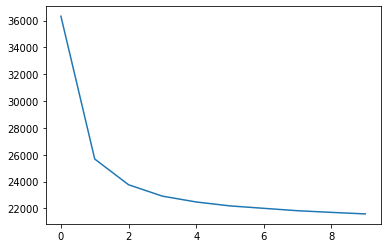

In [79]:
res = []

for i in range(num_epoch):
    cum_loss = 0
    for j,[image,label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        image = Variable(image).cuda()
        mu, logvar, output = model(image)
        
        loss = loss_function(output, image, mu, logvar)
        cum_loss += loss
        loss.backward()
        optimizer.step()
    res.append(cum_loss / len(train_loader))

# Train graph
plt.plot(res)
plt.show()

### 8) Make anomaly data

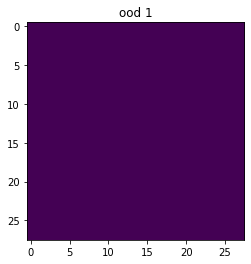

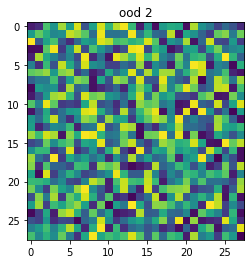

In [80]:
ood1 = np.zeros((28, 28), dtype=np.float32)

plt.imshow(ood1)
plt.title("ood 1")
plt.show()

ood2 = np.random.random((28, 28))

plt.imshow(ood2)
plt.title("ood 2")
plt.show()

### Test

In [81]:
for j,[in_dist,label] in enumerate(test_loader):
    break
in_dist = torch.unsqueeze(in_dist[0], 0)
in_recon_prob = model.get_recon_prob(in_dist.cuda())

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([1, 28, 28, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [82]:
out_dist = np.random.random((1, 1, 28, 28))

out_dist = torch.FloatTensor(out_dist).cuda()
out_recon_prob = model.get_recon_prob(out_dist)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1, 1, 28, 28])) that is different to the input size (torch.Size([1, 28, 28, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [84]:
in_recon_prob, out_recon_prob

(tensor(110.3578, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1126.5494, device='cuda:0', grad_fn=<DivBackward0>))